In [ ]:
import numpy as np
import pandas as pd
import datetime  
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(101)

%matplotlib inline

#plot styles
sns.set_style('white') 


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [ ]:
users = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
users.head()


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [ ]:
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [ ]:
users.rename(columns={'object_id':'user_id'}, inplace=True)

In [ ]:
engagements = pd.read_csv('takehome_user_engagement.csv')
engagements.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [ ]:
engagements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [ ]:
engagements.time_stamp = pd.to_datetime(engagements.time_stamp)
engagements_2 = engagements.set_index('time_stamp').groupby('user_id')['visited'].resample('D').count()
engagements_2 = pd.DataFrame(engagements_2)
engagements_2.head()

visited
user_id time_stamp         
1       2014-04-22        1
2       2013-11-15        1
        2013-11-16        0
        2013-11-17        0
        2013-11-18        0

In [ ]:
engagements_2 = engagements_2.rolling(window=7, min_periods=1).sum()


In [ ]:
engagements_2.reset_index(inplace=True)
engagements_2.head()


,user_id,time_stamp,visited
0,1,2014-04-22,1.0
1,2,2013-11-15,2.0
2,2,2013-11-16,2.0
3,2,2013-11-17,2.0
4,2,2013-11-18,2.0


In [ ]:
engagements_3 = engagements_2.groupby('user_id')[['visited']].max()
engagements_3.head()

,visited
user_id,
1,1.0
2,3.0
3,2.0
4,3.0
5,4.0


In [ ]:
engagements_3.loc[engagements_3['visited'] >= 3, 'adopted_user'] = 1
engagements_3.loc[engagements_3['visited'] < 3, 'adopted_user'] = 0


In [ ]:
engagements_3['visited'] = engagements_3['visited'].astype(int)
engagements_3['adopted_user'] = engagements_3['adopted_user'].astype(int)

In [ ]:
engagements_3.reset_index(inplace=True) 
engagements_3.head()


,user_id,visited,adopted_user
0,1,1,0
1,2,3,1
2,3,2,0
3,4,3,1
4,5,4,1


In [ ]:
df = engagements_3.merge(users, how='inner', on='user_id', sort=True)
df.head()

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,3,1,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,4,1,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [ ]:
df.isnull().sum()

user_id                          0
visited                          0
adopted_user                     0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
dtype: int64

In [ ]:
df['invited_by_user_id'].fillna(0, inplace=True)
df['invited_by_user_id'] = df['invited_by_user_id'].astype(int)


In [ ]:
df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time)
df['active_days'] = df['last_session_creation_time'] - df['creation_time']
df['active_days'] = df['active_days'].dt.days


In [ ]:
df.head()

,user_id,visited,adopted_user,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days
0,1,1,0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803,-16183
1,2,3,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316,-16025
2,3,2,0,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525,-15784
3,4,3,1,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151,-15847
4,5,4,1,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240,-15723


In [ ]:
df_ml = df[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
              'org_id', 'invited_by_user_id', 'active_days', 'adopted_user' ]]


In [ ]:
df_ml.adopted_user.value_counts()


1    8015
0     808
Name: adopted_user, dtype: int64

In [ ]:
df_ml_class1 = df_ml[df_ml['adopted_user']==1]
df_ml_class0 = df_ml[df_ml['adopted_user']==0]

In [ ]:
df_ml_class1_sampled = df_ml_class1.sample(n=len(df_ml_class0), random_state=101)

In [ ]:
df_ml_balanced = df_ml_class1_sampled.append(df_ml_class0)

In [ ]:
df_ml_balanced.adopted_user.value_counts()

1    808
0    808
Name: adopted_user, dtype: int64

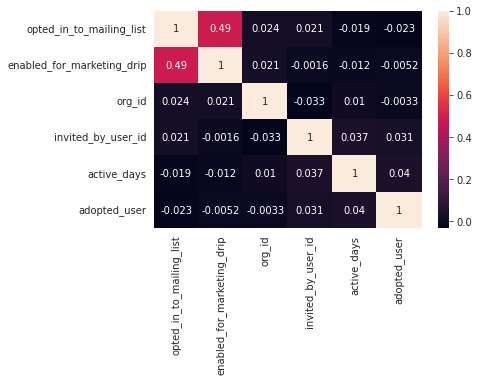

In [ ]:
corr = df_ml_balanced.corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns, yticklabels=corr.columns)


In [ ]:
creation_source_dum = pd.get_dummies(df_ml_balanced['creation_source'], drop_first=True)


In [ ]:
df_ml_balanced.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,adopted_user
538,GUEST_INVITE,0,1,56,6965,-15919,1
1962,SIGNUP_GOOGLE_AUTH,0,0,51,0,-15981,1
8498,SIGNUP_GOOGLE_AUTH,0,0,121,0,-15904,1
4025,SIGNUP_GOOGLE_AUTH,1,1,2,0,-16096,1
4394,SIGNUP,1,0,178,0,-16092,1


In [ ]:
df_ml_balanced.drop(['creation_source'], axis=1, inplace=True)

In [ ]:
X = pd.concat([df_ml_balanced, creation_source_dum], axis=1)
X.drop(['adopted_user'], axis=1, inplace=True)
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_days,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
538,0,1,56,6965,-15919,0,0,0,0
1962,0,0,51,0,-15981,0,0,0,1
8498,0,0,121,0,-15904,0,0,0,1
4025,1,1,2,0,-16096,0,0,0,1
4394,1,0,178,0,-16092,0,0,1,0


In [ ]:
y = df_ml_balanced['adopted_user']
y.head()


538     1
1962    1
8498    1
4025    1
4394    1
Name: adopted_user, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [ ]:
clf_RF = RandomForestClassifier(random_state=101, n_jobs = -1)
clf_RF.fit(X_train, y_train)
y_predicted_RF = clf_RF.predict(X_test)

clf_LR = LogisticRegression(random_state=101, n_jobs = -1)
clf_LR.fit(X_train, y_train)
y_predicted_LR = clf_LR.predict(X_test)

clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)
y_predicted_NB = clf_NB.predict(X_test)


In [ ]:
print("Random Forest:") 
print(classification_report(y_test, y_predicted_RF))
print('\n')

print("Logistic Regression:") 
print(classification_report(y_test, y_predicted_LR)) 
print('\n')

print("GaussianNB:") 
print(classification_report(y_test, y_predicted_NB)) 

Random Forest:
              precision    recall  f1-score   support

           0       0.51      0.48      0.50       248
           1       0.49      0.51      0.50       237

    accuracy                           0.50       485
   macro avg       0.50      0.50      0.50       485
weighted avg       0.50      0.50      0.50       485



Logistic Regression:
              precision    recall  f1-score   support

           0       0.57      0.41      0.48       248
           1       0.52      0.67      0.59       237

    accuracy                           0.54       485
   macro avg       0.54      0.54      0.53       485
weighted avg       0.54      0.54      0.53       485



GaussianNB:
              precision    recall  f1-score   support

           0       0.52      0.46      0.48       248
           1       0.49      0.55      0.52       237

    accuracy                           0.50       485
   macro avg       0.50      0.50      0.50       485
weighted avg       0.5